In [1]:
import pathlib; from pathlib import Path; import pandas as pd
import os ; import pathlib as pl ; from pprint import pformat ; import flopy ; import git ; import matplotlib.pyplot as plt
import numpy as np ; from flopy.plot.styles import styles  ;from modflow_devtools.misc import get_env, timed 

write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p04"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'B_p04_V01'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('B_p04_V01') ; output_folder.mkdir(exist_ok=True)

In [4]:
parameters      = {"ex-gwt-mt3dms-p04a": {"mixelm": 0},"ex-gwt-mt3dms-p04b": {"mixelm": -1},"ex-gwt-mt3dms-p04c": {"mixelm": 1},}
parameter_units = {"mixelm": "unitless"}                                      ; length_units = "meters" ; time_units = "days"
legendtxt_mod1  = ["MT3DMS - FD", "MT3DMS - TVD", "MT3DMS - MOC", "MF6 - FD"] ; legendtxt_mod2 = ["MF6 - FD", "MF6 - TVD", "MF6 - FD", "MF6 - TVD"]

In [5]:
# Parameters 
nlay = 1        # Number of layers
nrow = 100      # Number of rows
ncol = 100      # Number of columns
delr = 10.0     # Column width ($m$)
delc = 10.0     # Row width ($m$)
delz = 1.0      # Layer thickness ($m$)
top = 0.0      # Top of the model ($m$)
prsity = 0.14  # Porosity
perlen = 365   # Simulation time ($days$)
k11 = 1.0      # Horizontal hydraulic conductivity ($m/d$)
qwell = 0.01   # Volumetric injection rate ($m^3/d$)
cwell = 1000.0 # Concentration of injected water ($mg/L$)
al = 2.0       # Longitudinal dispersivity ($m$)
trpt = 0.1      # Ratio of transverse to longitudinal dispersitivity
dmcoef = 1.0e-9  # Molecular diffusion coefficient ($m^2/d$)

perlen = [1000.0]
nper = len(perlen)
nstp = [100]
tsmult = [1.0]
sconc = 0.0
dt0 = 0.3
ath1 = al * trpt
xt3d = [False]
botm = [top - delz]  # Model geometry
k33 = k11            # Vertical hydraulic conductivity ($m/d$)
icelltype = 0

Lx = (ncol - 1) * delr
Ly = (nrow - 1) * delc
Ls = np.sqrt(Lx**2 + Ly**2)
v  = 1.0
q  = v * prsity
h1 = q * Ls
a  = -1
b  = -1
c  = 1

nouter = 100
ninner = 300
hclose = 1e-6
rclose = 1e-6
relax  = 1.0
    
percel = 0.5  # HMOC parameters
itrack = 3
wd = 0.5
dceps = 1.0e-5
nplane = 1
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph

tdis_rc = []
tdis_rc.append((perlen, nstp, 1.0))

In [6]:
idomain       = np.ones((nlay, nrow, ncol), dtype=int)       ; icbund = 1    #  (k,  i,  j),  flow,   conc
spd_mf6 = {0: [[(0, 79, 20), qwell, cwell]]}

In [7]:
# MOFLOW | MT3DMS
def build_models(sim_name, mixelm=0, silent=False):
    name = "p04-mf6"
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package     (imsgwf, [gwf.name])

    flopy.mf6.ModflowGwfdis      (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                                  idomain=np.ones((nlay, nrow, ncol), dtype=int),filename=f"{gwfname}.dis")
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True,filename=f"{gwfname}.npf")
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")   
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")
    x = gwf.modelgrid.xcellcenters
    y = gwf.modelgrid.ycellcenters
    d = abs(a * x + b * y + c) / np.sqrt(2)
    strt = h1 - d / Ls * h1
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    chdspd = []
    for i in np.arange(nrow):
        chdspd.append([(0, i, 0), strt[i, 0]])
        chdspd.append([(0, i, ncol - 1), strt[i, ncol - 1]])
    for j in np.arange(1, ncol - 1):
        chdspd.append([(0, 0, j), strt[0, j]])
        chdspd.append([(0, nrow - 1, j), strt[nrow - 1, j]])
    chdspd = {0: chdspd}
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),stress_period_data=chdspd,save_flows=False,pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
                              printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                         
    gwtname = "gwt_" + name
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")
    gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,
                                  linear_acceleration="BICGSTAB",scaling_method="NONE",reordering_method="NONE",
                                  relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=1,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None,distcoef=None,filename=f"{gwtname}.mst")                                  # cnc ?
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")])
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return sim
def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)    ; assert success, pformat(buff)

In [8]:
def plot_results(mf6, idx, leglab2, ax=None):
    mf6.simulation_data.mfpath.get_sim_path()
    gwt = mf6.get_model(list(mf6.model_names)[1])  ; ucnobj_mf6 = gwt.output.concentration()  ;     conc_mf6 = ucnobj_mf6.get_alldata()
    with styles.USGSPlot() as fs:
        sim_name = mf6.name
        plt.rcParams["lines.dashed_pattern"] = [3, 3]
        if ax is None:
            fig = plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
            ax = fig.add_subplot(1, 1, 1, aspect="equal")
        x = gwt.modelgrid.xcellcenters  ; y = gwt.modelgrid.ycellcenters  ; levels = [0.15, 1.0, 2.0, 5.0] ; mm = flopy.plot.PlotMapView(model=gwt)
        cs2 = mm.contour_array(conc_mf6[0, 0, :, :], levels=levels, colors="r", linestyles="--")  
        if plot_show:
            plt.show()

run_models took 2231.47 ms


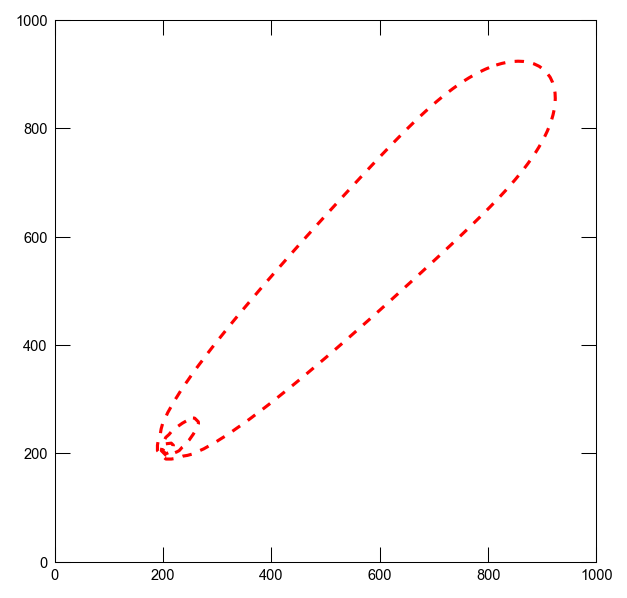

In [9]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    sim = build_models(key, **parameter_dict)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx, legendtxt_mod2[idx])  # legendtxt_mod1[idx], legendtxt_mod2[idx])
scenario(0)   # 0 1 2 

In [10]:
conc_mf6

C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value in

NameError: name 'conc_mf6' is not defined